In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import seaborn as sns 

1.Overview

Trước khi bắt đầu huấn luyện mô hình AI để dự đoán kẻ chiến thắng, chúng ta cần hiểu rõ 'chiến trường'. Bộ dữ liệu này chứa tới 60,000 trận đấu lịch sử với 109 đặc trưng (features) khác nhau.                 
Nhìn vào bảng dữ liệu mẫu, ta thấy mỗi dòng đại diện cho một trận đấu giữa Pokemon 1 và Pokemon 2. Các chỉ số quan trọng quyết định thắng bại như `HP`, `Attack`, `Defense`, `Speed` đều hiện diện đầy đủ. Đặc biệt, cột `Winner` chính là mục tiêu (Target variable) mà chúng ta cần dự đoán. Liệu chỉ số cao hơn có đồng nghĩa với chiến thắng? Dữ liệu sẽ trả lời câu hỏi đó.

In [50]:
df= pd.read_csv('DATASET.csv')

2. Data info

**Máy tính thích những con số, nhưng thế giới Pokemon lại đầy màu sắc và tên gọi.**                        
Đa số các cột là `int64` và `float64`: Đây là tin tốt! Các chỉ số sức mạnh (Stats) đã ở dạng số, sẵn sàng để tính toán.
Các cột object: Tên Pokemon, Loại (Type 1, Type 2), và Khả năng đặc biệt (Abilities). Để mô hình hiểu được sự khắc chế hệ (Ví dụ: Nước thắng Lửa), sau này chúng ta sẽ cần chuyển đổi (encode) những dữ liệu văn bản này sang dạng số.

In [51]:
# 1. Display shape, first 10 rows, and info of the dataset
print(df.shape)
print(df.head(10))
# C. Hiển thị Info (Dạng bảng thay vì text thô)
display(Markdown("### Data info"))

# Tạo bảng tóm tắt thông tin cột
info_df = pd.DataFrame({
    'Dtype': df.dtypes,
    'Non-Null Count': df.count(),
    'Missing Values': df.isnull().sum(),
    '% Missing': (df.isnull().sum() / len(df)) * 100
})

# Hiển thị bảng info có thanh màu mức độ thiếu dữ liệu
display(info_df.style.bar(subset=['% Missing'], color='#AEC6CF', vmin=0, vmax=100)
                     .format({'% Missing': '{:.1f}%'}))

(60309, 87)
   First_pokemon  Second_pokemon  Winner   Name_P1  HP_P1  Attack_P1  \
0            266             298   298.0  Larvitar     50         64   
1            702             701   701.0  Virizion     91         90   
2            191             668   668.0   Togetic     55         40   
3            237             683   683.0    Slugma     40         40   
4            151             231   151.0   Omastar     70         60   
5            657             752   657.0    Joltik     50         47   
6            192             134   134.0      Natu     40         50   
7             73             545   545.0    Machop     70         80   
8            220             763   763.0    Pineco     50         65   
9            302              31    31.0   Wingull     40         30   

   Defense_P1  Generation_P1  Legendary_P1                 Name_P2  ...  \
0          50              2         False                 Nuzleaf  ...   
1          72              5          True   

### Data info

,Dtype,Non-Null Count,Missing Values,% Missing
First_pokemon,int64,60309,0,0.0%
Second_pokemon,int64,60309,0,0.0%
Winner,float64,50255,10054,16.7%
Name_P1,object,60244,65,0.1%
HP_P1,int64,60309,0,0.0%
Attack_P1,int64,60309,0,0.0%
Defense_P1,int64,60309,0,0.0%
Generation_P1,int64,60309,0,0.0%
Legendary_P1,bool,60309,0,0.0%
Name_P2,object,60246,63,0.1%


In [52]:
# 2. Display data types of columns
from IPython.display import display, Markdown

# Tạo bảng hiển thị kiểu dữ liệu của các cột
dtypes_df = pd.DataFrame({
    'Column': df.columns,
    'Dtype': df.dtypes.values  # Sử dụng .values để tránh trùng lặp
})

# Hiển thị bảng kiểu dữ liệu
display(Markdown("### Data types"))
display(dtypes_df)

### Data types

,Column,Dtype
0,First_pokemon,int64
1,Second_pokemon,int64
2,Winner,float64
3,Name_P1,object
4,HP_P1,int64
...,...,...
82,p2_sp_defense,float64
83,p2_speed,float64
84,p2_type1,object
85,p2_type2,object


In [53]:
# 3. Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


Number of duplicate rows: 2036


**"Phát hiện 2036 dòng dữ liệu bị trùng lặp hoàn toàn."**
Trong Data Science, việc để dữ liệu trùng lặp giống như việc cho học sinh ôn thi cùng một bài toán 2000 lần - nó sẽ khiến mô hình 'học vẹt' (overfitting) thay vì hiểu quy luật thực sự của chiến thắng. Để đảm bảo tính công bằng cho việc đánh giá mô hình sau này, chúng ta cần loại bỏ ngay những bản ghi dư thừa này."

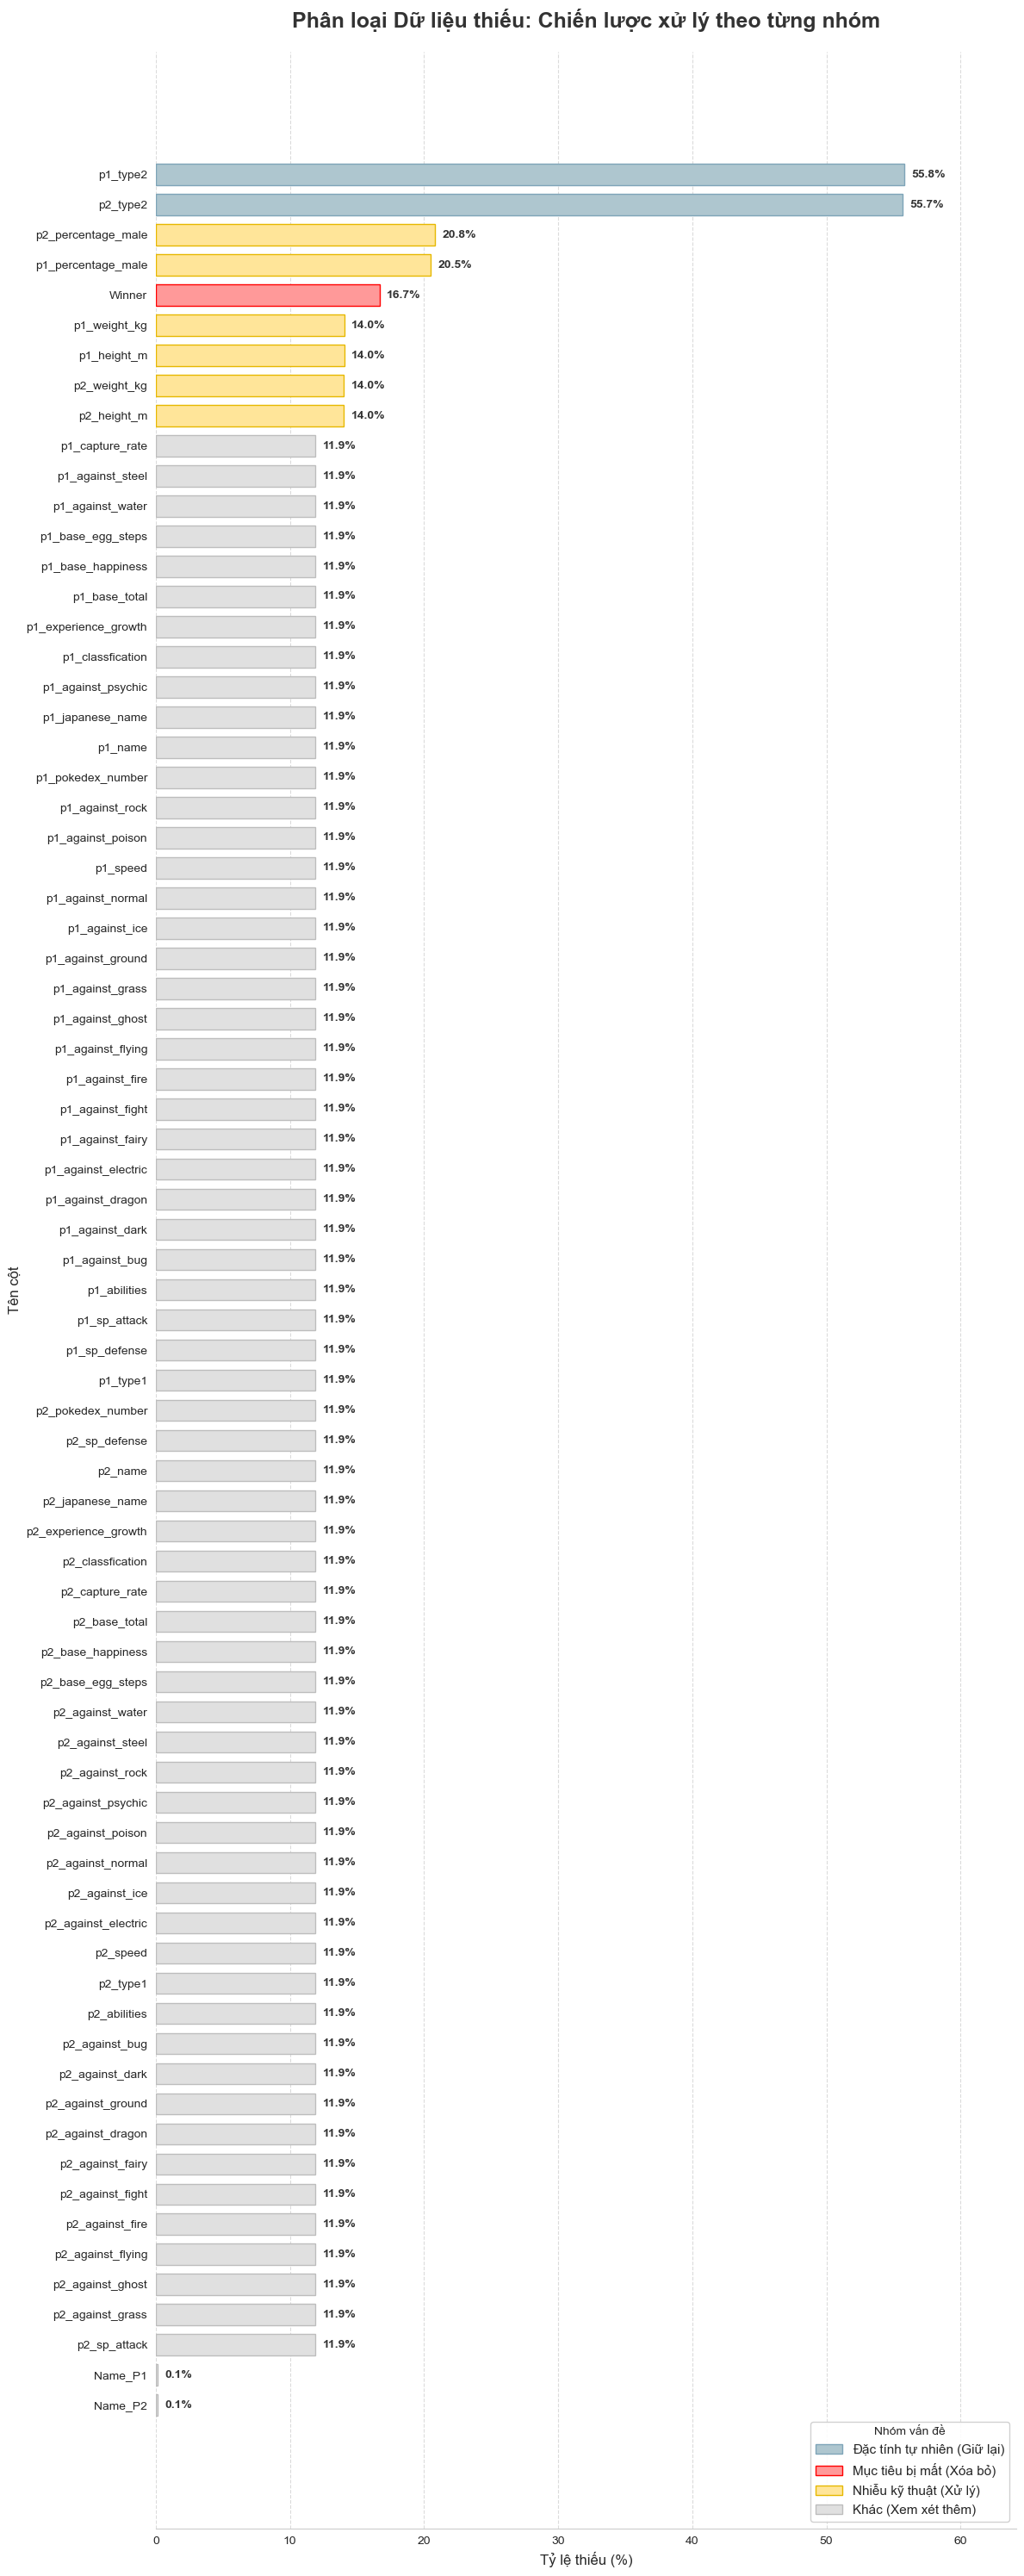

⚠️ Cảnh báo: Có 10054 trận đấu không xác định được người thắng.


In [54]:
#4. Visualize missing data 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import pandas as pd
import numpy as np

# --------------------------------------------------------------------------

# --- 2. TÍNH TOÁN SỐ LIỆU ---
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = missing_percentage[missing_percentage > 0].sort_values(ascending=True) # Sort True để vẽ từ dưới lên (thành trên xuống trong barh)

# --- 3. PHÂN LOẠI (Logic cũ của bạn) ---
def classify_column(col):
    if 'type2' in col or 'Type 2' in col:
        return 'Đặc tính tự nhiên'
    elif 'Winner' in col:
        return 'Mục tiêu bị mất'
    elif 'percentage_male' in col or 'height' in col or 'weight' in col:
        return 'Nhiễu kỹ thuật'
    else:
        return 'Khác'

missing_data_groups = missing_data.index.to_series().apply(classify_column)

# --- 4. THIẾT LẬP MÀU SẮC ---
color_map = {
    'Mục tiêu bị mất': ('#ff9999', '#ff0000'),     # Đỏ
    'Đặc tính tự nhiên': ('#AEC6CF', '#7ea4b8'),   # Xanh
    'Nhiễu kỹ thuật': ('#ffe599', '#e6b800'),      # Vàng
    'Khác': ('#e0e0e0', '#bdbdbd')                 # Xám nhạt hơn cho dễ nhìn
}

colors = [color_map[g][0] for g in missing_data_groups]
edgecolors = [color_map[g][1] for g in missing_data_groups]

# --- 5. VẼ BIỂU ĐỒ CẢI TIẾN ---
# Tính chiều cao biểu đồ dựa trên số lượng cột (Mỗi cột cần khoảng 0.4 inch)
dynamic_height = max(6, len(missing_data) * 0.4) 

plt.figure(figsize=(12, dynamic_height)) # Chiều ngang 12, chiều cao động
sns.set_style("whitegrid")

# Vẽ Bar chart NGANG (barh)
bars = plt.barh(missing_data.index, missing_data.values, 
                color=colors, edgecolor=edgecolors, height=0.7, zorder=3)

# Thêm số liệu bên cạnh thanh
x_max = missing_data.values.max()
for bar in bars:
    width = bar.get_width()
    label_y = bar.get_y() + bar.get_height() / 2
    
    # Logic hiển thị text: Nếu thanh quá ngắn thì in đậm, nếu thanh dài thì in thường
    text_color = '#333'
    font_weight = 'bold' if width > 0 else 'normal'
    
    plt.text(width + (x_max * 0.01), label_y, 
             f'{width:.1f}%', 
             va='center', fontsize=10, color=text_color, fontweight=font_weight)

# --- 6. TRANG TRÍ ---
plt.title("Phân loại Dữ liệu thiếu: Chiến lược xử lý theo từng nhóm", 
          fontsize=18, fontweight='bold', pad=20, color='#333')
plt.xlabel("Tỷ lệ thiếu (%)", fontsize=12)
plt.ylabel("Tên cột", fontsize=12)

# Giới hạn trục X để đẹp hơn (thêm 5-10% khoảng trống bên phải cho text)
plt.xlim(0, x_max * 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.grid(axis='y', visible=False) # Tắt grid ngang để đỡ rối

# --- LEGEND ---
legend_elements = [
    Patch(facecolor=color_map['Đặc tính tự nhiên'][0], edgecolor=color_map['Đặc tính tự nhiên'][1], label='Đặc tính tự nhiên (Giữ lại)'),
    Patch(facecolor=color_map['Mục tiêu bị mất'][0], edgecolor=color_map['Mục tiêu bị mất'][1], label='Mục tiêu bị mất (Xóa bỏ)'),
    Patch(facecolor=color_map['Nhiễu kỹ thuật'][0], edgecolor=color_map['Nhiễu kỹ thuật'][1], label='Nhiễu kỹ thuật (Xử lý)'),
    Patch(facecolor=color_map['Khác'][0], edgecolor=color_map['Khác'][1], label='Khác (Xem xét thêm)')
]

# Đặt Legend ra góc phải dưới hoặc góc phải trên tùy data
plt.legend(handles=legend_elements, loc='lower right', fontsize=11, title="Nhóm vấn đề", frameon=True, framealpha=0.9)

sns.despine(left=True, bottom=False)
plt.tight_layout()
plt.show()

if 'Winner' in df.columns:
    print(f"⚠️ Cảnh báo: Có {df['Winner'].isnull().sum()} trận đấu không xác định được người thắng.")

## Giải mã "Vùng đất Khuyết" (The Missing Lands)

 Khi quét qua hệ thống, chúng ta phát hiện ra bản đồ dữ liệu không hề bằng phẳng. Có những "hố sâu" dữ liệu bị thiếu được hiển thị rõ ràng trên biểu đồ.

Tuy nhiên, **không phải mọi sự thiếu hụt đều giống nhau**. Dựa vào biểu đồ phân loại phía trên, chúng ta có 3 câu chuyện riêng biệt cần giải quyết:

### 1. 🟦 Câu chuyện màu Xanh: "Sự thiếu hụt... Hoàn hảo"
*   **Nhân vật chính:** Các cột `p1_Type 2`, `p2_Type 2` (và các biến thể `p1_type2`, `p2_type2`).
*   **Hiện trạng:** Những cột này cao chót vót, chiếm tới **~55%** dữ liệu bị thiếu. Thoạt nhìn, đây có vẻ là thảm họa thu thập dữ liệu.
*   **Sự thật (Insight):** Hãy nhớ về **Pikachu**. Chú chuột điện này chỉ mang hệ *Electric*. Pikachu không có hệ thứ 2. Trong thế giới Pokemon, rất nhiều loài là "Đơn hệ" (Single-type).
*   **Kết luận:** Khoảng trống này **không phải là lỗi**, mà là **đặc tính tự nhiên**. Giá trị `NaN` ở đây thực chất mang ý nghĩa là *"Không có hệ phụ"*.
*   **👉 Chiến lược:** Chúng ta sẽ **Giữ lại** và điền vào đó giá trị **"None"**. Đây là thông tin quý giá giúp AI phân biệt giữa Pokemon đơn hệ và đa hệ.

### 2. 🟥 Câu chuyện màu Đỏ: "Báo động Đỏ tại Đấu trường"
* Câu chuyện:  Winner là biến mục tiêu (Target Variable) - thứ mà chúng ta đang cố gắng dự đoán. Một trận đấu mà không biết ai thắng thì hoàn toàn vô giá trị đối với bài toán Học máy có giám sát (Supervised Learning).
* Chiến lược: Không có cách nào để "cứu" dữ liệu này một cách an toàn (nếu tự điền người thắng, ta đang dạy sai cho mô hình). Hành động bắt buộc là xóa bỏ hoàn toàn những dòng thiếu Winner. 
### 3. 🟨 Câu chuyện màu Vàng: 
* Câu chuyện: Đây là những thông số vật lý cơ bản. Việc thiếu hụt ở đây đại diện cho "Nhiễu kỹ thuật" (Technical Noise). Có thể do lỗi trong quá trình thu thập dữ liệu, hoặc đối với percentage_male, có thể do một số Pokémon là vô tính (genderless).
* Chiến lược: Dữ liệu này vẫn quý giá và tỷ lệ thiếu chưa quá cao.
    - Với chiều cao (height_m): Có thể thay thế (impute) bằng giá trị Median (trung vị) để tránh bị ảnh hưởng bởi các Pokémon khổng lồ ngoại lai.
    - Với giới tính (percentage_male): Cần kiểm tra kỹ. Nếu là Pokémon vô tính, hãy điền một giá trị đặc biệt (như -1). Nếu là lỗi, hãy điền trung bình/trung vị của nhóm cùng hệ.

### 4:Tiếng ồn nền (Thanh màu xám - Tỷ lệ thấp, đồng đều)
Một loạt các cột stat_trash_...
* Câu chuyện: Sự đồng đều kỳ lạ này gợi ý về một lỗi hệ thống mang tính cấu trúc. Có vẻ như số lượng bản ghi (rows) bị hỏng hoàn toàn ở các trường thông tin phụ này, hoặc chúng đến từ một nguồn dữ liệu con bị lỗi.
* Chiến lược: Vì tỷ lệ rất nhỏ và đây là các cột thông tin phụ (như tên nhóm "Khác" gợi ý), ta có thể cân nhắc xóa các dòng này nếu chúng trùng lặp với các lỗi khác, hoặc đơn giản là điền giá trị 0/Median để mô hình vẫn chạy được mà không ảnh hưởng nhiều đến độ chính xác.
